In [7]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt

import pandas as pd

## Color detection of ants
This project aims at deteting the color of ants in images.

![alt text](ants_color_wheel.jpg "Ants color wheel")


### Data
**Information from lab:** \
FOR PROJECT on COULOUR DETECTION
In colour_digitalization.zip --> an excel file with 28770 spécimens and the information relative to the "human being digitalization". 
Column names are mostly explicit. Last column max_distance corresponds to the maximum distance among the six distances between colours observed on head-thorax-abdomen (six couples: head-thorax; thorax-abdomen, etc). If the distance is small (<30), we could consider the specimen as homogeneous in terms of colour variation.


**original** \
This folder contains 38578 images of ants. \
In these images there is the measurement stick 

**colour_digitalization.xlsx** \
Contains data about each ant. \
Specimen is the unique identifier of each ant and this is also used as file name for each ant image. \
In this file we have the RGB values for each of the body parts of the ant head, thorax, abdomen and the x,y coordinates where these values have been taken \

**Some maybe useful links:**

https://medium.com/@rajat01221/the-mathematics-behind-color-detection-in-machine-learning-algorithms-fc79a8eddf98

https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

https://link.springer.com/chapter/10.1007/978-3-031-19647-8_5





#### Reading in some ant images from original folder 

In [ ]:
def read_image_file_names(folder_path):
    # List all files in the folder and sort them
    all_files = sorted(os.listdir(folder_path))

    # Filter only the image files (e.g., with extensions .jpg, .png)
    image_file_names = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    return image_file_names


In [16]:
# Path to the folder containing images
folder_path = '/Volumes/T7 Shield/AntProject/original'

image_file_names = read_image_file_names(folder_path)



In [ ]:
#Number of images in folder
print(len(image_file_names))

38578


In [17]:
#Looking at 100 images
first_100_images = image_file_names[0:100]

# Reading in the 100 images
images = []
for image_file in first_100_images:
    image_path = os.path.join(folder_path, image_file)
    
    if image_file.startswith('._'):
        continue
    try:
        img = imread(image_path)
        images.append(img)
    except Exception as e:
        print(f"Error reading {image_file}: {e}")

anic32-066653_p_1.jpg


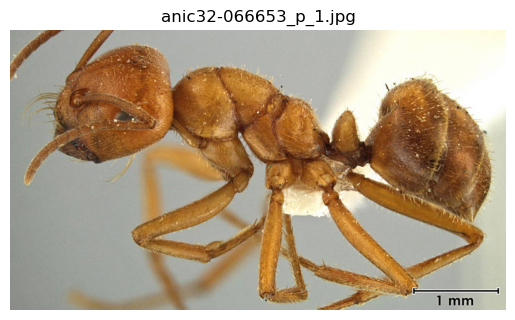

In [52]:
index = 36
print(image_file_names[index])
plt.imshow(images[index])
plt.axis('off')  # Optional: turn off the axis for a cleaner look
plt.title(image_file_names[index])
plt.show()

#### Reading in colour_digitalization.xlsx

In [25]:
# Read the Excel file
df = pd.read_excel('/Volumes/T7 Shield/AntProject/colour_digitalization.xlsx', sheet_name='Sheet1', engine='openpyxl')


/Users/lisavind/miniconda3/envs/envuni/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
df.head() #No color here?

,specimen,original_file,species,x_head,y_head,x_thorax,y_thorax,x_abdomen,y_abdomen,r_head,g_head,b_head,r_thorax,g_thorax,b_thorax,r_abdomen,g_abdomen,b_abdomen,max_distance
0,casent0280684,casent0280684_p_1.jpg,Acanthognathus brevicornis,541.761428,611.801353,710.781834,634.915325,1186.833259,449.712645,108,54,18,82,37,16,91,52,21,15.64
1,casent0914659,casent0914659_p_1.jpg,Acanthognathus brevicornis,343.088620,585.595543,569.682016,656.890638,1071.440567,336.927097,119,68,15,118,74,37,166,129,77,26.18
2,usnment00445715,usnment00445715_p_1.jpg,Acanthognathus lentus,401.710873,565.733114,689.236409,515.149918,859.621911,256.909390,226,205,138,203,149,75,206,164,88,30.90
3,casent0178718,casent0178718_p_1.jpg,Acanthognathus ocellatus,161.119440,600.342669,318.193575,661.574959,898.569193,390.023064,153,108,79,113,69,40,149,105,58,18.46
4,casent0914660,casent0914660_p_1.jpg,Acanthognathus ocellatus,477.114498,653.588138,796.587315,637.614498,1116.060132,339.439868,142,89,39,107,68,29,110,68,28,17.92


In [27]:
print(len(df))

28770


We have differing number of ants in dataframe and in original data folder. Filter out those who are not included?

In [43]:
mask = df['original_file'].isin(first_100_images)
index_first_100 = df.index[mask]

# Display the indices
print(index_first_100)

Index([12120, 12125, 12126, 12130, 12131, 12134, 12135, 12142, 12143, 12150,
       12151, 12152, 12153, 12156, 12159, 12160, 12165, 12166, 12171, 12172,
       12175, 12176, 12180, 12181, 12184, 12187, 12188, 12199, 12200, 12201,
       12202, 12203, 12207, 12208, 12217, 12218, 12219, 12220, 12221, 12223,
       12224, 12226, 12227, 12228, 12231, 12232, 12233, 12234, 12237, 12238,
       12239, 12244, 12246, 12258, 12259, 12260, 12261, 12264, 12265, 12273,
       12274, 12275, 12276, 12280, 12282, 12283, 12288, 12289, 12290, 12292,
       12295, 12296, 12304, 12305, 12306, 12307, 12315, 12319, 12320, 12321,
       12330, 12331],
      dtype='int64')


In [59]:
df.iloc[index_first_100[0]]

#anic32-032237-2_p_1.jpg

specimen                 anic32-066653
original_file    anic32-066653_p_1.jpg
species           Melophorus anderseni
x_head                      366.046823
y_head                      651.264214
x_thorax                     574.12709
y_thorax                    581.003344
x_abdomen                  1138.916388
y_abdomen                   462.100334
r_head                             165
g_head                              89
b_head                              29
r_thorax                           161
g_thorax                            97
b_thorax                            35
r_abdomen                          101
g_abdomen                           66
b_abdomen                           38
max_distance                     42.86
Name: 12120, dtype: object

In [66]:
#Extracting thorax color value
color_value = df[['r_thorax', 'g_thorax', 'b_thorax']].iloc[index_first_100[0]]

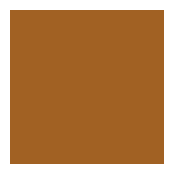

In [67]:
#Plotting thorax color value
color = (color_value.iloc[0] / 255, color_value.iloc[1] / 255, color_value.iloc[2] / 255)

# Display the color as a patch
plt.figure(figsize=(2, 2))
plt.imshow([[color]])
plt.axis('off')
plt.show()